# Opening a New Shopping Mall in Trivandrum, India
## Finding the best location to open a new shopping mall in the city of Trivandrum

- Build a dataframe of neighborhoods in Trivandrum, India by web scraping the data from Wikipedia page
- Get the geographical coordinates of the neighborhoods
- Obtain the venue data for the neighborhoods from Foursquare API
- Explore and cluster the neighborhoods
- Select the best cluster to open a new shopping mall

## 1. Importing libraries


In [25]:
import json 
import folium
import requests
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pylab as plt
from sklearn.metrics import silhouette_score 
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# %conda install -c conda-forge folium # uncomment this folium is not installed
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)



print('Libraries Imported')

Libraries Imported


## 2. Scraping data from Wikipedia to a Data Frame

In [2]:
data = requests.get('https://en.wikipedia.org/wiki/Category:Suburbs_of_Thiruvananthapuram').text
soup = BeautifulSoup(data, 'html.parser')
neighborhood_list = []
for place in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhood_list.append(place.text)
tvm_neighborhood  = pd.DataFrame({"Neighborhood": neighborhood_list})
tvm_neighborhood.sort_values(by =['Neighborhood'], inplace = True)
tvm_neighborhood.head(10)

Neighborhood
0                         Aakkulam
1  Ambalathara, Thiruvananthapuram
2                       Aryankuzhi
3                    Attakulangara
4                          Attukal
5                       Beemapally
6        Chala, Thiruvananthapuram
7                       Chengallur
8                 Connemara Market
9                        East Fort

## 3. Cleaning the Data Frame and adding geographical coordinates

In [3]:
latitude = []
longitude = []
for coord in tvm_neighborhood['Neighborhood']:
    coordinates = Nominatim(user_agent = 'tvm_explorer').geocode('{},Trivandrum'.format(coord))
    if coordinates == None:
        tvm_neighborhood.drop(tvm_neighborhood.loc[tvm_neighborhood['Neighborhood'] == coord].index, inplace = True)
    else:
        latitude.append(coordinates.latitude)
        longitude.append(coordinates.longitude)
tvm_neighborhood["Latitude"] = latitude 
tvm_neighborhood['Longitude'] = longitude
print("Summary \n Number of neighborhoods = {}".format(tvm_neighborhood.shape[0]+1))
tvm_neighborhood.head(10)

Summary 
 Number of neighborhoods = 58


Neighborhood  Latitude  Longitude
0                          Aakkulam  8.516299  76.892079
1   Ambalathara, Thiruvananthapuram  8.451039  76.949729
3                     Attakulangara  8.479351  76.947455
4                           Attukal  8.465874  76.966623
5                        Beemapally  8.456100  76.934447
6         Chala, Thiruvananthapuram  8.482888  76.949420
7                        Chengallur  8.493971  76.979829
8                  Connemara Market  8.502751  76.951210
9                         East Fort  8.482810  76.947675
10                     Jyothi Nagar  8.526479  76.940834

## 4. Visualising the neighboorhood on map

In [4]:
tvm_loc = Nominatim(user_agent = 'tvm_explorer').geocode('Trivandrum, India') 
map_tvm = folium.Map(location = [tvm_loc.latitude, tvm_loc.longitude], zoom_start = 12) 
num = 1
for lat, lng, hood in zip(tvm_neighborhood['Latitude'], tvm_neighborhood['Longitude'], tvm_neighborhood['Neighborhood']):
    label = hood,
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat,lng],
    radius = 5,
    popup = label,
    color = 'blue',
    fill = True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_tvm)
    num += 1
print('{} locations added!'.format(num))
map_tvm   

58 locations added!


## 5. Defining Foursquare Credentials

In [5]:
CLIENT_ID = '42SUYWC3PZCLNQ4L3FSEUUUHAAETDTJU5LD2ECTDFGXFDWO4' # your Foursquare ID
CLIENT_SECRET = 'HAF0SRYNPFGD2HY0Z5ZJRIFLU5LFZISZDQCTO0V4HY10WNKO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

## 6. Exploring the neighborhoods of Trivandrum

In [6]:
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [7]:
# obtaining neaby venues in Trivandrum
tvm_venues = getNearbyVenues(names = tvm_neighborhood['Neighborhood'],latitudes = tvm_neighborhood['Latitude'], longitudes = tvm_neighborhood['Longitude'])

Aakkulam
Ambalathara, Thiruvananthapuram
Attakulangara
Attukal
Beemapally
Chala, Thiruvananthapuram
Chengallur
Connemara Market
East Fort
Jyothi Nagar
Kaithamukku
Kamaleswaram
Kaniyapuram
Kannammoola
Karamana
Kariavattom
Kazhakoottam
Kesavadasapuram
Konchiravila
Kowdiar
Kudappanakunnu
Kuzhivila
Manacaud
Mannanthala
Nalanchira
Nemom
Ooruttambalam
Palayam, Thiruvananthapuram
Palkulangara
Pangappara
Pappanamcode
Paravankunnu
Pattom
Peroorkada
Pettah, Thiruvananthapuram
Peyad
Pongumoodu
Poojappura
Poonthura
Pothencode
Pulayanarkotta
Sasthamangalam
Sreekaryam
Thampanoor
Thirumala, Thiruvananthapuram
Thonnakkal
Thumba
Ulloor
Valiyavila
Vanchiyoor
Vattiyoorkavu
Vazhayila
Vazhuthacaud
Vellayambalam
Vellayani
Vettucaud
Vizhinjam


In [8]:
print(tvm_venues.shape)
print('There are {} uniques categories'.format(len(tvm_venues['Venue Category'].unique())))
tvm_venues.head()

(3547, 7)
There are 91 uniques categories


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Aakkulam               8.516299               76.892079   
1     Aakkulam               8.516299               76.892079   
2     Aakkulam               8.516299               76.892079   
3     Aakkulam               8.516299               76.892079   
4     Aakkulam               8.516299               76.892079   

                     Venue  Venue Latitude  Venue Longitude     Venue Category  
0       The Dhabha Project        8.539703        76.878585  Indian Restaurant  
1     Veli Tourist Village        8.509979        76.889980             Arcade  
2      Shanghumukham Beach        8.479029        76.912421              Beach  
3      Sulthan's Sulaimani        8.556664        76.876321           Tea Room  
4  Marginfree Hyper Market        8.529659        76.885833   Department Store

In [9]:
#Numbe of venues returned for each neighbourhood
vn_count = pd.DataFrame(tvm_venues.groupby('Neighborhood').count()['Venue'])
vn_count.rename(columns={'Venue':'No. of Venues'}, inplace = True)
vn_count

No. of Venues
Neighborhood                                  
Aakkulam                                    48
Ambalathara, Thiruvananthapuram             43
Attakulangara                               78
Attukal                                     71
Beemapally                                  54
Chala, Thiruvananthapuram                   81
Chengallur                                  72
Connemara Market                            91
East Fort                                   81
Jyothi Nagar                                79
Kaithamukku                                 89
Kamaleswaram                                57
Kaniyapuram                                 32
Kannammoola                                 86
Karamana                                    40
Kariavattom                                 39
Kazhakoottam                                43
Kesavadasapuram                             84
Konchiravila                                48
Kowdiar                                     73
Kudappanakunnu                              85
Kuzhivila                                   10
Manacaud                                    65
Mannanthala                                 84
Nalanchira                                  78
Nemom                                        4
Ooruttambalam                                6
Palayam, Thiruvananthapuram                 90
Palkulangara                                87
Pangappara                                  84
Pappanamcode                                62
Paravankunnu                                74
Pattom                                      84
Peroorkada                                  53
Pettah, Thiruvananthapuram                  85
Peyad                                        4
Pongumoodu                                  53
Poojappura                                  44
Poonthura                                   43
Pothencode                                   4
Pulayanarkotta                              51
Sasthamangalam                              79
Sreekaryam                                  73
Thampanoor                                  91
Thirumala, Thiruvananthapuram               92
Thonnakkal                                  84
Thumba                                      84
Ulloor                                      69
Valiyavila                                  55
Vanchiyoor                                  91
Vattiyoorkavu                               75
Vazhayila                                   63
Vazhuthacaud                                84
Vellayambalam                               84
Vellayani                                   13
Vettucaud                                   30
Vizhinjam                                   41

## 7. Analysing each neighborhoods

In [10]:
# one hot encoding
tvm_onehot = pd.get_dummies(tvm_venues[['Venue Category']], prefix="", prefix_sep="")

# neighborhood column back to dataframe
tvm_onehot['Neighborhoods'] = tvm_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = list(tvm_onehot.columns[-1:]) + list(tvm_onehot.columns[:-1])
tvm_onehot = tvm_onehot[fixed_columns]

print(tvm_onehot.shape)
tvm_onehot.head()

(3547, 92)


Neighborhoods  Accessories Store  Airport  American Restaurant  Arcade  \
0      Aakkulam                  0        0                    0       0   
1      Aakkulam                  0        0                    0       1   
2      Aakkulam                  0        0                    0       0   
3      Aakkulam                  0        0                    0       0   
4      Aakkulam                  0        0                    0       0   

   Asian Restaurant  Athletics & Sports  Auto Dealership  Auto Garage  \
0                 0                   0                0            0   
1                 0                   0                0            0   
2                 0                   0                0            0   
3                 0                   0                0            0   
4                 0                   0                0            0   

   Automotive Shop  BBQ Joint  Bakery  Beach  Bistro  Boutique  \
0                0          0       0      0       0         0   
1                0          0       0      0       0         0   
2                0          0       0      1       0         0   
3                0          0       0      0       0         0   
4                0          0       0      0       0         0   

   Breakfast Spot  Burger Joint  Bus Line  Bus Station  Café  \
0               0             0         0            0     0   
1               0             0         0            0     0   
2               0             0         0            0     0   
3               0             0         0            0     0   
4               0             0         0            0     0   

   Chinese Restaurant  City  Clothing Store  Coffee Shop  \
0                   0     0               0            0   
1                   0     0               0            0   
2                   0     0               0            0   
3                   0     0               0            0   
4                   0     0               0            0   

   Comfort Food Restaurant  Convenience Store  Department Store  \
0                        0                  0                 0   
1                        0                  0                 0   
2                        0                  0                 0   
3                        0                  0                 0   
4                        0                  0                 1   

   Design Studio  Dessert Shop  Diner  Electronics Store  \
0              0             0      0                  0   
1              0             0      0                  0   
2              0             0      0                  0   
3              0             0      0                  0   
4              0             0      0                  0   

   Fast Food Restaurant  Fish Market  Food  Food & Drink Shop  Food Court  \
0                     0            0     0                  0           0   
1                     0            0     0                  0           0   
2                     0            0     0                  0           0   
3                     0            0     0                  0           0   
4                     0            0     0                  0           0   

   Food Service  Food Truck  Gym  Gym / Fitness Center  Halal Restaurant  \
0             0           0    0                     0                 0   
1             0           0    0                     0                 0   
2             0           0    0                     0                 0   
3             0           0    0                     0                 0   
4             0           0    0                     0                 0   

   Harbor / Marina  Historic Site  History Museum  Hotel  Hotel Pool  \
0                0              0               0      0           0   
1                0              0               0      0           0   
2                0              0               0      0       

## 8. Grouping rows by neighborhood and by taking the frequency of occurrence of each category and dropping the outlier venues.

In [23]:
tvm_grouped = tvm_onehot.groupby('Neighborhoods').sum().reset_index()
tvm_grouped_1 =  tvm_grouped.drop(['Airport', 'Auto Dealership','Auto Garage','Automotive Shop','Beach',
                                  'City','Electronics Store','Fish Market','Harbor / Marina',
                                  'History Museum', 'Hotel', 'Hotel Pool',
                                  'Intersection', 'Lighthouse', 'Liquor Store', 'Lounge',
                                  'Motorcycle Shop','Neighborhood','Planetarium','Resort','Sculpture Garden',
                                   'Stadium', 'Student Center','Temple','Train Station',
                                  'Tennis Stadium'], axis = 1)
tvm_grouped_2 = tvm_grouped_1.sum(axis = 1)
list1 = list(tvm_grouped_2)
print(list1)

[41, 34, 63, 56, 42, 66, 61, 76, 66, 68, 77, 43, 28, 73, 35, 35, 39, 70, 39, 61, 74, 7, 51, 70, 64, 1, 3, 75, 75, 70, 51, 58, 70, 44, 73, 4, 42, 38, 34, 4, 41, 66, 66, 74, 76, 70, 70, 61, 48, 78, 66, 56, 70, 72, 8, 24, 18]


## 9. Creating Data Frame for Shopping Malls in the Neighbourhood

In [14]:
malls = len(tvm_grouped[tvm_grouped["Shopping Mall"] > 0])
print('Number of Neighborhoods where there is minimum one mall:', malls)
tvm_mall = tvm_grouped[["Neighborhoods","Shopping Mall"]]
tvm_mall['Number of Venue'] = list1
tvm_mall

Number of Neighborhoods where there is minimum one mall: 48


C:\Users\kewin\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Neighborhoods  Shopping Mall  Number of Venue
0                          Aakkulam              1               41
1   Ambalathara, Thiruvananthapuram              2               34
2                     Attakulangara              2               63
3                           Attukal              2               56
4                        Beemapally              3               42
5         Chala, Thiruvananthapuram              2               66
6                        Chengallur              4               61
7                  Connemara Market              3               76
8                         East Fort              2               66
9                      Jyothi Nagar              2               68
10                      Kaithamukku              4               77
11                     Kamaleswaram              1               43
12                      Kaniyapuram              0               28
13                      Kannammoola              3               73
14                         Karamana              1               35
15                      Kariavattom              0               35
16                     Kazhakoottam              0               39
17                  Kesavadasapuram              4               70
18                     Konchiravila              2               39
19                          Kowdiar              4               61
20                   Kudappanakunnu              2               74
21                        Kuzhivila              1                7
22                         Manacaud              2               51
23                      Mannanthala              4               70
24                       Nalanchira              2               64
25                            Nemom              0                1
26                    Ooruttambalam              0                3
27      Palayam, Thiruvananthapuram              3               75
28                     Palkulangara              3               75
29                       Pangappara              4               70
30                     Pappanamcode              1               51
31                     Paravankunnu              3               58
32                           Pattom              4               70
33                       Peroorkada              2               44
34       Pettah, Thiruvananthapuram              3               73
35                            Peyad              0                4
36                       Pongumoodu              2               42
37                       Poojappura              2               38
38                        Poonthura              2               34
39                       Pothencode              1                4
40                   Pulayanarkotta              1               41
41                   Sasthamangalam              4               66
42                       Sreekaryam              1               66
43                       Thampanoor              3               74
44    Thirumala, Thiruvananthapuram              2               76
45                       Thonnakkal              4               70
46                           Thumba              4               70
47                           Ulloor              2               61
48                       Valiyavila              2               48
49                       Vanchiyoor              3               78
50                    Vattiyoorkavu              1               66
51                        Vazhayila              2               56
52                     Vazhuthacaud              4               70
53                    Vellayambalam              4               72
54                        Vellayani              0                8
55                        Vettucaud              0               24
56                        Vizhinjam              0               18

## 10. Clustering Neighborhood 

<Figure size 1152x576 with 0 Axes>

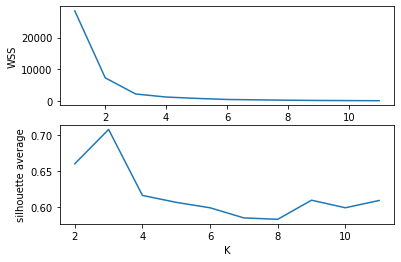

In [30]:
# Choosing the correct value of number of clusters(k) using elbow method silhouette average method
norm = tvm_mall.copy()
norm["normalised_s"] = (norm["Shopping Mall"]-norm["Shopping Mall"].mean())/norm["Shopping Mall"].std()
norm["normalised_v"] = (norm["Number of Venue"]-norm["Number of Venue"].mean())/norm["Number of Venue"].std()
tvm_clustering = norm.drop(['Neighborhoods', 'Shopping Mall'], axis = 1 ) #Taking only the normalised values from tvm_malls
wss = []
silhouette_avg = []
k = [x for x in range(1,12)]

for i in k:
    kmeans = KMeans(n_clusters = i).fit(tvm_clustering)
    wss.append(kmeans.inertia_)
    if i>1:
        silhouette_avg.append(silhouette_score(tvm_clustering, kmeans.labels_))
    
plt.figure(figsize=(16,8))
fig, axs = plt.subplots(2)
axs[0].plot(k, wss)
axs[1].plot(k[1:],silhouette_avg )
axs[0].set_xlabel('K')
axs[0].set_ylabel('WSS')
axs[1].set_xlabel('K')
axs[1].set_ylabel('silhouette average')
plt.show()

##### From the plot we can see that the Elbow Point is at k = 3, so we choose the number of cluster to be 3

In [31]:
# Modelling
km = KMeans(n_clusters = 3, random_state = 5)
km.fit(tvm_clustering)
clusters = km.labels_
clusters

array([2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 0,
       2, 1, 1, 0, 0, 1, 1, 1, 2, 1, 1, 2, 1, 0, 2, 2, 2, 0, 2, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 2, 0])

## Adding the values of clusters to the Data Frame

In [32]:
tvm = tvm_neighborhood[['Neighborhood','Latitude','Longitude']].reset_index(drop = True)
tvm['No. of shopping malls'] = tvm_mall['Shopping Mall']
tvm['num. of Venues'] = tvm_mall['Number of Venue']
tvm['Cluster'] = clusters
tvm.sort_values(by=['Cluster'], inplace = True)
tvm.reset_index(drop = True, inplace = True)
tvm

Neighborhood  Latitude  Longitude  \
0                         Vizhinjam  8.380442  76.988816   
1                         Kuzhivila  8.403151  77.069930   
2                             Peyad  8.513969  77.019523   
3                        Pothencode  8.618423  76.897693   
4                     Ooruttambalam  8.434331  77.051913   
5                             Nemom  8.452167  77.010054   
6                         Vellayani  8.445338  76.988529   
7                        Vanchiyoor  8.496961  76.938389   
8       Palayam, Thiruvananthapuram  8.503034  76.950565   
9                        Pangappara  8.524112  76.936057   
10                     Paravankunnu  8.459327  76.945810   
11                           Pattom  8.524112  76.936057   
12       Pettah, Thiruvananthapuram  8.494206  76.927514   
13                    Vellayambalam  8.511472  76.962296   
14                     Vazhuthacaud  8.524112  76.936057   
15                   Sasthamangalam  8.513167  76.972229   
16                       Sreekaryam  8.548949  76.917187   
17                        Vazhayila  8.547029  76.973892   
18    Thirumala, Thiruvananthapuram  8.501966  76.991846   
19                       Thonnakkal  8.524112  76.936057   
20                           Thumba  8.524112  76.936057   
21                           Ulloor  8.530005  76.928621   
22                    Vattiyoorkavu  8.529457  76.986468   
23                       Thampanoor  8.487667  76.952434   
24                     Palkulangara  8.487369  76.936530   
25                      Mannanthala  8.524112  76.936057   
26                       Nalanchira  8.546746  76.935739   
27                      Kaithamukku  8.488970  76.937830   
28                     Jyothi Nagar  8.526479  76.940834   
29                        East Fort  8.482810  76.947675   
30                 Connemara Market  8.502751  76.951210   
31                       Chengallur  8.493971  76.979829   
32                      Kannammoola  8.502278  76.927191   
33        Chala, Thiruvananthapuram  8.482888  76.949420   
34                          Attukal  8.465874  76.966623   
35                          Kowdiar  8.522754  76.960475   
36                    Attakulangara  8.479351  76.947455   
37                   Kudappanakunnu  8.550538  76.956385   
38                  Kesavadasapuram  8.524112  76.936057   
39                       Beemapally  8.456100  76.934447   
40                       Valiyavila  8.506975  76.998838   
41  Ambalathara, Thiruvananthapuram  8.451039  76.949729   
42                     Kamaleswaram  8.467127  76.948242   
43                   Pulayanarkotta  8.521361  76.912744   
44                         Karamana  8.481707  76.966303   
45                        Poonthura  8.451039  76.949729   
46                       Poojappura  8.489845  76.973602   
47                       Pongumoodu  8.540419  76.924214   
48                      Kariavattom  8.561482  76.882980   
49                     Kazhakoottam  8.556815  76.872753   
50                       Peroorkada  8.537289  76.966499   
51                     Konchiravila  8.453999  76.956684   
52                     Pappanamcode  8.470212  76.981113   
53                        Vettucaud  8.494621  76.900147   
54                         Manacaud  8.474080  76.947041   
55                      Kaniyapuram  8.587665  76.856070   
56                         Aakkulam  8.516299  76.892079   

    No. of shopping malls  num. of Venues  Cluster  
0                       0              18        0  
1                       1               7        0  
2                       0               4        0  
3                       1               4        0  
4                       0               3        0  
5                       0               1        0  
6                       0               8        0  
7                       3              78        1  
8                       3              75        1  
9           

##### Visualising Data

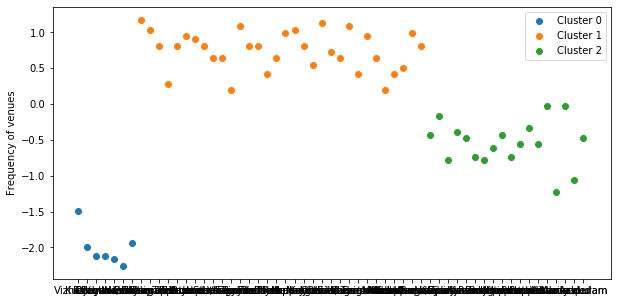

<Figure size 432x288 with 0 Axes>

In [33]:
tvm_mall_new = tvm.copy()
tvm_mall_new['No. of shopping malls'] = (tvm_mall_new['No. of shopping malls']-tvm_mall_new['No. of shopping malls'].mean())/tvm_mall_new['No. of shopping malls'].std()
tvm_mall_new['num. of Venues'] = (tvm_mall_new['num. of Venues']-tvm_mall_new['num. of Venues'].mean())/tvm_mall_new['num. of Venues'].std()

t1 = tvm_mall_new.loc[tvm_mall_new['Cluster'] == 0]
t2 = tvm_mall_new.loc[tvm_mall_new['Cluster'] == 1]
t3 = tvm_mall_new.loc[tvm_mall_new['Cluster'] == 2]



plt.figure(figsize=(10,5))

plt.scatter(t1['Neighborhood'], t1['num. of Venues'], label = 'Cluster 0')
plt.scatter(t2['Neighborhood'], t2['num. of Venues'], label = 'Cluster 1')
plt.scatter(t3['Neighborhood'], t3['num. of Venues'], label = 'Cluster 2')

plt.ylabel('Frequency of venues')
plt.legend()
plt.show()


In [34]:
map_clusters = folium.Map(location = [tvm_loc.latitude, tvm_loc.longitude], zoom_start = 10.5)
x = np.arange(4)
color = ['blue', 'orange', 'green']

ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tvm['Latitude'], tvm['Longitude'], tvm['Neighborhood'], tvm['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color[cluster],
        fill=True,
        fill_color=color[cluster],
        fill_opacity=0.7).add_to(map_clusters)
#map_clusters.save('map_clusters.html')      
map_clusters

## 11. Examining Clusters

##### Cluster 0

In [35]:
tvm.loc[tvm['Cluster'] == 0].reset_index(drop=True)

Neighborhood  Latitude  Longitude  No. of shopping malls  num. of Venues  \
0      Vizhinjam  8.380442  76.988816                      0              18   
1      Kuzhivila  8.403151  77.069930                      1               7   
2          Peyad  8.513969  77.019523                      0               4   
3     Pothencode  8.618423  76.897693                      1               4   
4  Ooruttambalam  8.434331  77.051913                      0               3   
5          Nemom  8.452167  77.010054                      0               1   
6      Vellayani  8.445338  76.988529                      0               8   

   Cluster  
0        0  
1        0  
2        0  
3        0  
4        0  
5        0  
6        0

#### Cluster 1

In [36]:
tvm.loc[tvm['Cluster'] == 1].reset_index(drop=True)

Neighborhood  Latitude  Longitude  No. of shopping malls  \
0                      Vanchiyoor  8.496961  76.938389                      3   
1     Palayam, Thiruvananthapuram  8.503034  76.950565                      3   
2                      Pangappara  8.524112  76.936057                      4   
3                    Paravankunnu  8.459327  76.945810                      3   
4                          Pattom  8.524112  76.936057                      4   
5      Pettah, Thiruvananthapuram  8.494206  76.927514                      3   
6                   Vellayambalam  8.511472  76.962296                      4   
7                    Vazhuthacaud  8.524112  76.936057                      4   
8                  Sasthamangalam  8.513167  76.972229                      4   
9                      Sreekaryam  8.548949  76.917187                      1   
10                      Vazhayila  8.547029  76.973892                      2   
11  Thirumala, Thiruvananthapuram  8.501966  76.991846                      2   
12                     Thonnakkal  8.524112  76.936057                      4   
13                         Thumba  8.524112  76.936057                      4   
14                         Ulloor  8.530005  76.928621                      2   
15                  Vattiyoorkavu  8.529457  76.986468                      1   
16                     Thampanoor  8.487667  76.952434                      3   
17                   Palkulangara  8.487369  76.936530                      3   
18                    Mannanthala  8.524112  76.936057                      4   
19                     Nalanchira  8.546746  76.935739                      2   
20                    Kaithamukku  8.488970  76.937830                      4   
21                   Jyothi Nagar  8.526479  76.940834                      2   
22                      East Fort  8.482810  76.947675                      2   
23               Connemara Market  8.502751  76.951210                      3   
24                     Chengallur  8.493971  76.979829                      4   
25                    Kannammoola  8.502278  76.927191                      3   
26      Chala, Thiruvananthapuram  8.482888  76.949420                      2   
27                        Attukal  8.465874  76.966623                      2   
28                        Kowdiar  8.522754  76.960475                      4   
29                  Attakulangara  8.479351  76.947455                      2   
30                 Kudappanakunnu  8.550538  76.956385                      2   
31                Kesavadasapuram  8.524112  76.936057                      4   

    num. of Venues  Cluster  
0               78        1  
1               75        1  
2               70        1  
3               58        1  
4               70        1  
5               73        1  
6               72        1  
7               70        1  
8               66        1  
9               66        1  
10              56        1  
11              76        1  
12              70        1  
13              70        1  
14              61        1  
15              66        1  
16              74        1  
17              75        1  
18              70        1  
19              64        1  
20              77        1  
21              68        1  
22              66        1  
23              76        1  
24              61        1  
25              73        1  
26              66        1  
27              56        1  
28              61        1  
29              63        1  
30              74        1  
31              70        1

##### Cluster 2

In [37]:
tvm.loc[tvm['Cluster'] == 2].reset_index(drop=True)

Neighborhood  Latitude  Longitude  \
0                        Beemapally  8.456100  76.934447   
1                        Valiyavila  8.506975  76.998838   
2   Ambalathara, Thiruvananthapuram  8.451039  76.949729   
3                      Kamaleswaram  8.467127  76.948242   
4                    Pulayanarkotta  8.521361  76.912744   
5                          Karamana  8.481707  76.966303   
6                         Poonthura  8.451039  76.949729   
7                        Poojappura  8.489845  76.973602   
8                        Pongumoodu  8.540419  76.924214   
9                       Kariavattom  8.561482  76.882980   
10                     Kazhakoottam  8.556815  76.872753   
11                       Peroorkada  8.537289  76.966499   
12                     Konchiravila  8.453999  76.956684   
13                     Pappanamcode  8.470212  76.981113   
14                        Vettucaud  8.494621  76.900147   
15                         Manacaud  8.474080  76.947041   
16                      Kaniyapuram  8.587665  76.856070   
17                         Aakkulam  8.516299  76.892079   

    No. of shopping malls  num. of Venues  Cluster  
0                       3              42        2  
1                       2              48        2  
2                       2              34        2  
3                       1              43        2  
4                       1              41        2  
5                       1              35        2  
6                       2              34        2  
7                       2              38        2  
8                       2              42        2  
9                       0              35        2  
10                      0              39        2  
11                      2              44        2  
12                      2              39        2  
13                      1              51        2  
14                      0              24        2  
15                      2              51        2  
16                      0              28        2  
17                      1              41        2

## 12. Observations:
From the above result we can see that 
- Cluster 0 has the least number of malls. It is also the least developed among the three clusters.
- Cluster 1 has the maximum number of malls concentrated. It is the central part of the city and is the most crowed place with highest number of venues around it.
- Cluster 2 has moderate number of malls and is moderatly crowded.

## 13. Conclution
From the observations we have conclude the following
- Cluster 2 is the most ideal place place to construct a shopping mall. The Malls is expected to face optimium competion. Cluster 2 has considerable number of venues in and around it.
- Cluster 0 and Cluster 1 is the least preferred place to contructed; former being under developed, owner will find little to no busiesness in this area; whereas cluster 1 is highly crowed and heavily competitive, it is adviced to not constructs shopping malls as the chances of getting it shut down due to competition is high.
